## Final Project Submission

Please fill out:
* Student name: Linh Mai
* Student pace: self paced 
* Scheduled project review date/time: June 5th, 2020
* Instructor name: Jeff Herman
* Blog post URL: https://linhmai19.github.io/

# Import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import scipy.stats as stats

In [2]:
df = pd.read_csv('cleaned_kc_house_data.csv')
df = df.drop('Unnamed: 0', 1)
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,1.0,1951,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,1.0,1965,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19688 entries, 0 to 19687
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19688 non-null  object 
 1   price          19688 non-null  float64
 2   bedrooms       19688 non-null  int64  
 3   bathrooms      19688 non-null  float64
 4   sqft_living    19688 non-null  int64  
 5   sqft_lot       19688 non-null  int64  
 6   floors         19688 non-null  float64
 7   waterfront     19688 non-null  float64
 8   view           19688 non-null  float64
 9   condition      19688 non-null  int64  
 10  grade          19688 non-null  int64  
 11  sqft_above     19688 non-null  int64  
 12  basement       19688 non-null  float64
 13  yr_built       19688 non-null  int64  
 14  zipcode        19688 non-null  int64  
 15  lat            19688 non-null  float64
 16  long           19688 non-null  float64
 17  sqft_living15  19688 non-null  int64  
 18  sqft_l

# Explore the relationships between variables

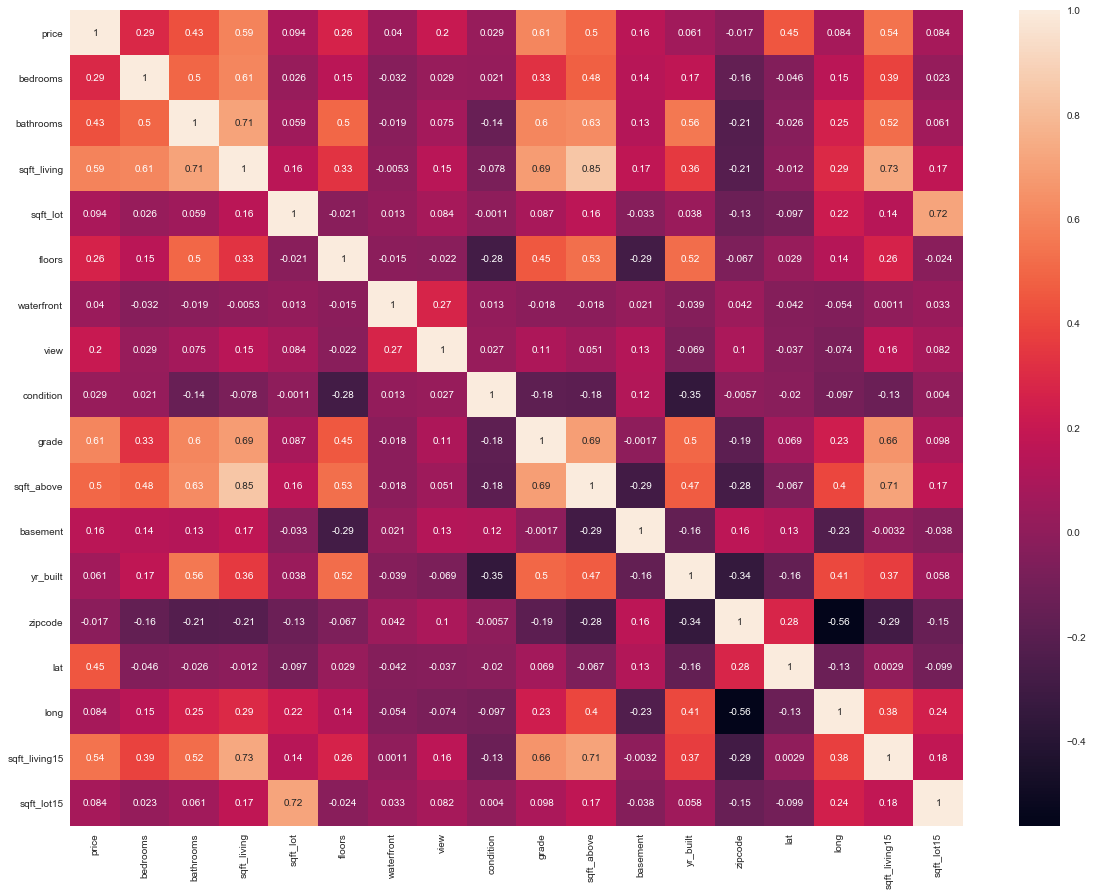

In [5]:
plt.subplots(figsize=(20,15))
sns.heatmap(df.corr(), annot=True)
plt.show()

In [7]:
# Calculate correlation of each feature to price and sort in descending order

corr = df.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Target', 'level_1':'Features', 0:'Correlation_Values'})
corr = corr.loc[corr['Target'] == 'price']
corr.sort_values(by = 'Correlation_Values', ascending = False)

,Target,Features,Correlation_Values
0,price,price,1.000000
9,price,grade,0.605622
3,price,sqft_living,0.592574
16,price,sqft_living15,0.539829
10,price,sqft_above,0.502429
14,price,lat,0.445085
2,price,bathrooms,0.429121
1,price,bedrooms,0.287471
5,price,floors,0.263144
7,price,view,0.200772


In [10]:
# Calculate correlation between each feature and choose the most highly correlated features
corr = df.corr()
corr = corr.stack().reset_index()
corr = corr.rename(columns = {'level_0':'Feature_1', 'level_1':'Feature_2', 0:'Correlation_Values'})
corr = corr.loc[corr['Feature_1'] != corr['Feature_2']]
corr.loc[corr['Correlation_Values'].abs() > 0.7].sort_values(by = 'Correlation_Values', ascending = False)

,Feature_1,Feature_2,Correlation_Values
64,sqft_living,sqft_above,0.846888
183,sqft_above,sqft_living,0.846888
70,sqft_living,sqft_living15,0.729976
291,sqft_living15,sqft_living,0.729976
89,sqft_lot,sqft_lot15,0.715798
310,sqft_lot15,sqft_lot,0.715798
196,sqft_above,sqft_living15,0.709667
298,sqft_living15,sqft_above,0.709667
39,bathrooms,sqft_living,0.707164
56,sqft_living,bathrooms,0.707164


## Eliminate Multicollinearity 

To avoid multicollinearity, we need to remove one of the features that are highly correlated together.

To decide which in the 2 features to drop, we compare each feature to the target. The feature that is less correlated to the target would be dropped.

In [11]:
df = df.drop(['sqft_above', 'sqft_living15', 'sqft_lot15'], axis=1).copy()

## Explore the top features

### a) Average price of home based on grade

In [19]:
df.groupby(by = 'grade')['grade'].count().sort_values(ascending = False)

grade
7     8840
8     5786
9     2122
6     1988
10     622
5      234
11      66
4       27
12       2
3        1
Name: grade, dtype: int64

Text(0.5, 1.0, 'Average Price of Home Based on Grade')

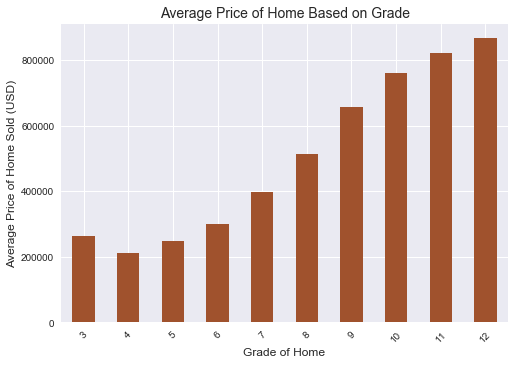

In [36]:
ax = df.groupby(['grade'])['price'].mean().plot(kind = 'bar', color='sienna')
ax.set_xlabel('Grade of Home', fontsize=12)
plt.xticks(rotation=45)
ax.set_ylabel('Average Price of Home Sold (USD)', fontsize=12)
ax.set_title('Average Price of Home Based on Grade', fontsize=14)